In [1]:
import pandas as pd 
import numpy as np

In [2]:
partition_num = 9

In [3]:
data = pd.read_parquet(f'jane-street-real-time-market-data-forecasting/train.parquet/partition_id={partition_num}/part-0.parquet')

In [4]:
for symbol in data['symbol_id'].unique():
    if data.loc[data['symbol_id']==symbol].feature_09.unique().shape[0] != 1:
        print(f"{symbol}- feature_09")
    if data.loc[data['symbol_id']==symbol].feature_10.unique().shape[0] != 1:
        print(f"{symbol}- feature_10")
    if data.loc[data['symbol_id']==symbol].feature_11.unique().shape[0] != 1:
        print(f"{symbol}- feature_11")

35- feature_09
35- feature_11
36- feature_09
36- feature_10
36- feature_11


In [5]:
print(f"feature_09: {data.feature_09.unique()}, shape: {data.feature_09.unique().shape}")
print(f"feature_10: {data.feature_10.unique()}, shape: {data.feature_10.unique().shape}")
print(f"feature_11: {data.feature_11.unique()}, shape: {data.feature_11.unique().shape}")

feature_09: [11 81  4 15  2 12 42 46 70 50 44  9 64 30 34 14 26 82 68 57 49 25], shape: (22,)
feature_10: [ 7  2  3  1 10  4  5  6 12], shape: (9,)
feature_11: [ 76  59  11   9 171  34  62 150 261 410 522  16  25 376  66  50 214  13
  40 158 539 534  24 388 230 336 297 195], shape: (28,)


In [6]:
# 실제 unique 조합 확인
unique_combinations = data[['feature_09', 'feature_10', 'feature_11']].drop_duplicates()

# 조합 수와 실제 조합들 출력
print(f"실제 unique 조합의 수: {len(unique_combinations)}")

# 각 조합의 출현 빈도도 확인
combination_counts = data.groupby(['feature_09', 'feature_10', 'feature_11']).size().reset_index(name='count')
combination_counts = combination_counts.sort_values('count', ascending=False)
print("\n전체 unique 조합:")
combination_counts.reset_index(drop=True)

실제 unique 조합의 수: 28

전체 unique 조합:


,feature_09,feature_10,feature_11,count
0,11,7,76,1027048
1,34,4,214,486904
2,9,3,25,327184
3,4,3,11,325248
4,50,1,522,324280
5,42,5,150,322344
6,26,12,158,319440
7,44,3,16,163592
8,70,7,410,163592
9,81,2,59,162624


In [7]:
def create_group_mapper(group_df):
    """
    그룹 매핑을 위한 dictionary 생성
    """
    return {
        (row['feature_09'], row['feature_10'], row['feature_11']): idx 
        for idx, row in group_df.iterrows()
    }

def map_to_group_vectorized(data, group_mapper):
    """
    벡터 연산을 사용하여 데이터를 그룹에 매핑
    """
    # 매핑을 위한 복합 키 생성
    combined_key = pd.Series(list(zip(data['feature_09'], 
                                    data['feature_10'], 
                                    data['feature_11'])))
    
    # numpy의 vectorize 사용하여 매핑
    vectorized_mapper = np.vectorize(lambda x: group_mapper.get(x, -1))
    
    return vectorized_mapper(combined_key)

In [8]:
group_info = combination_counts.reset_index(drop=True).drop('count', axis=1)

# 그룹 매퍼 생성
group_mapper = create_group_mapper(group_info)

# 그룹 매핑 실행
data['group'] = map_to_group_vectorized(data, group_mapper)

In [9]:
for i, x in enumerate(data.isnull().sum()):
    print(data.columns[i], x)

date_id 0
time_id 0
symbol_id 0
weight 0
feature_00 0
feature_01 0
feature_02 0
feature_03 0
feature_04 0
feature_05 0
feature_06 0
feature_07 0
feature_08 37752
feature_09 0
feature_10 0
feature_11 0
feature_12 0
feature_13 0
feature_14 0
feature_15 155568
feature_16 0
feature_17 25928
feature_18 0
feature_19 0
feature_20 0
feature_21 77440
feature_22 0
feature_23 0
feature_24 0
feature_25 0
feature_26 77440
feature_27 77440
feature_28 0
feature_29 0
feature_30 0
feature_31 77440
feature_32 61545
feature_33 61545
feature_34 0
feature_35 0
feature_36 0
feature_37 0
feature_38 0
feature_39 440778
feature_40 2
feature_41 116677
feature_42 440778
feature_43 2
feature_44 116677
feature_45 139
feature_46 139
feature_47 0
feature_48 0
feature_49 0
feature_50 440776
feature_51 0
feature_52 116676
feature_53 440776
feature_54 0
feature_55 116676
feature_56 0
feature_57 0
feature_58 61545
feature_59 0
feature_60 0
feature_61 0
feature_62 126
feature_63 96
feature_64 101
feature_65 139
feature_6

## 시각화

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def visualize_group_features(data, feature_cols, n_groups=21):
    # Set figure size
    plt.figure(figsize=(30, 45))

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 시각화 시작...")

    # Create time series for each group and feature
    print(f"[{datetime.now().strftime('%H:%M:%S')}] 그룹별 시계열 데이터 생성 중...")
    
    # Calculate grid dimensions
    n_features = len(feature_cols)
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] 그래프 그리기 시작...")
    
    # Create subplots
    for feature_idx, feature in enumerate(feature_cols):
        if (feature_idx + 1) % 10 == 0:
            print(f"[{datetime.now().strftime('%H:%M:%S')}] Feature 처리 중... ({feature_idx+1}/{n_features})")
        
        for group in range(n_groups):
            # Filter data for current group
            group_data = data[data['group'] == group]
            
            # Calculate time-based sum for the current group and feature
            time_sum = group_data.groupby('time_id')[feature].sum()
            
            # Calculate subplot position (features as rows, groups as columns)
            plt.subplot(n_features, n_groups, feature_idx * n_groups + group + 1)
            
            # Plot the data
            plt.plot(time_sum.index, time_sum.values)
            
            # Add titles and labels
            if group == 0:  # Only add feature name on the leftmost plot
                plt.ylabel(feature, rotation=0, ha='right')
            if feature_idx == 0:  # Only add group number on the top row
                plt.title(f'Group {group}')
            
            # Remove x-axis labels to save space
            plt.xticks([])
            
            # Remove y-axis labels for all but leftmost plots
            if group != 0:
                plt.yticks([])

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 레이아웃 조정 중...")
    plt.tight_layout()

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 그래프 표시 중...")
    plt.show()

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 작업 완료!")

In [11]:
# 여러 열을 리스트로 지정할 경우
columns_to_include = ['group', 'time_id', 'symbol_id', 'date_id']
null_df  = pd.concat([data.loc[:, (data.isnull().sum() != 0)].isnull(), data[columns_to_include]], axis=1)
null_df.head()

,feature_08,feature_15,feature_17,feature_21,feature_26,feature_27,feature_31,feature_32,feature_33,feature_39,...,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,group,time_id,symbol_id,date_id
0,False,True,True,False,False,False,False,True,True,True,...,True,True,False,False,False,False,0,0,0,1530
1,False,True,True,False,False,False,False,True,True,True,...,True,True,False,False,False,False,0,0,1,1530
2,False,True,True,False,False,False,False,True,True,True,...,True,True,False,False,False,False,9,0,2,1530
3,False,True,True,False,False,False,False,True,True,True,...,True,True,False,False,False,False,3,0,3,1530
4,False,True,True,False,False,False,False,True,True,True,...,True,True,False,False,False,False,25,0,4,1530


In [12]:
# # 시각화 실행z
# visualize_group_features(null_df, null_df.columns, n_groups=len(unique_combinations))

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def visualize_group_features(data, feature_cols):
    # Set figure size
    plt.figure(figsize=(30, 200))

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 시각화 시작...")

    # Calculate grid dimensions
    n_features = len(feature_cols)
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] 그래프 그리기 시작...")
    
    # Create subplots
    for feature_idx, feature in enumerate(feature_cols):
        if (feature_idx + 1) % 10 == 0:
            print(f"[{datetime.now().strftime('%H:%M:%S')}] Feature 처리 중... ({feature_idx+1}/{n_features})")
        
        # Calculate time-based sum for the current feature
        time_sum = data.groupby('time_id')[feature].sum()
        
        # Create subplot (인덱스를 1부터 시작하도록 수정)
        plt.subplot(n_features, 1, feature_idx + 1)
        
        # Plot the data
        plt.plot(time_sum.index, time_sum.values, linewidth=2)
        
        # Add labels and title
        plt.ylabel(feature, rotation=0, ha='right', labelpad=20)
        plt.title(f'Time Series for {feature}', pad=10)
        
        # Adjust x-axis ticks
        plt.xticks(rotation=45)
        
        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 레이아웃 조정 중...")
    
    # Adjust subplot spacing
    plt.subplots_adjust(
        left=0.1,      # 왼쪽 여백
        right=0.95,    # 오른쪽 여백
        bottom=0.05,   # 아래쪽 여백
        top=0.95,      # 위쪽 여백
        hspace=0.4     # 세로 방향 subplot 간격
    )

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 그래프 표시 중...")
    plt.show()

    print(f"[{datetime.now().strftime('%H:%M:%S')}] 작업 완료!")

[14:57:03] 시각화 시작...
[14:57:03] 그래프 그리기 시작...
[14:57:03] Feature 처리 중... (10/37)
[14:57:04] Feature 처리 중... (20/37)
[14:57:05] Feature 처리 중... (30/37)
[14:57:06] 레이아웃 조정 중...
[14:57:06] 그래프 표시 중...


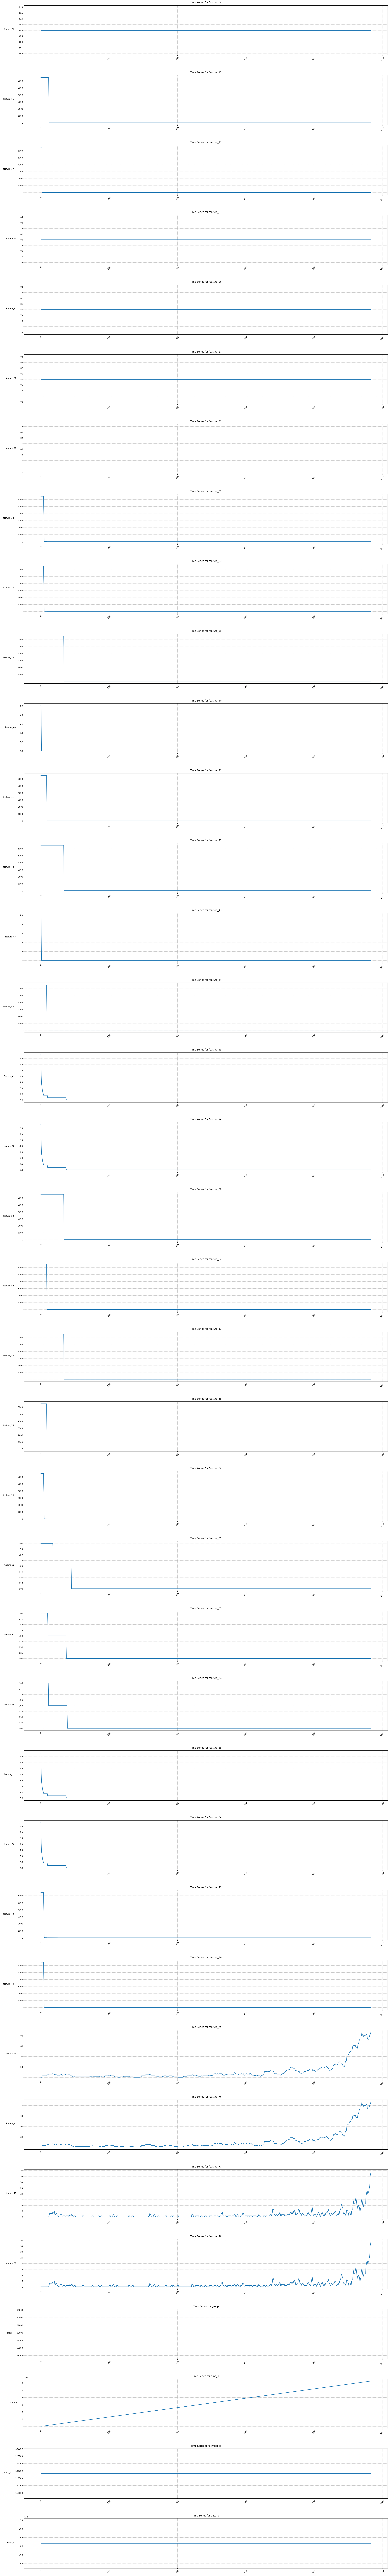

[14:57:09] 작업 완료!


In [14]:
visualize_group_features(null_df, null_df.columns)

In [15]:
partition_num

9